In [1]:
#import packages
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.signal as signal

In [18]:
# Load data
import mne
# raw = mne.io.read_raw_edf('EEG_recordings/208/mouse_208_day1_12_to_13.edf', preload=True)
# raw = mne.io.read_raw_edf('EEG_recordings/208/mouse_208_day2_12_to_13.edf', preload=True)
# raw = mne.io.read_raw_edf('EEG_recordings/268/mouse_268_day1_12_to_13.edf', preload=True)
# raw = mne.io.read_raw_edf('EEG_recordings/268/mouse_268_day2_12_to_13.edf', preload=True)
# raw = mne.io.read_raw_edf('EEG_recordings/346/mouse_346_day1_12_to_13.edf', preload=True)
raw = mne.io.read_raw_edf('EEG_recordings/346/mouse_346_day2_12_to_13.edf', preload=True)
raw

Extracting EDF parameters from F:\Makinson_lab\sleep\EEG_recordings\346\mouse_346_day2_12_to_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ...  3599.999 secs...


<RawEDF | mouse_346_day2_12_to_13.edf, 3 x 3686400 (3600.0 s), ~84.4 MB, data loaded>

In [22]:
#downsample
raw.resample(100)
sf = raw.info['sfreq']
print('Chan =', raw.ch_names)
print('Sampling frequency =', sf)
print('Data shape (channels, times) =', raw._data.shape)

Chan = ['EEG EEG1.1A-B', 'EEG EEG2.1A-B', 'EMG EEG3.1A-B']
Sampling frequency = 100.0
Data shape (channels, times) = (3, 360000)


In [24]:
raw._data[0].shape

(360000,)

In [23]:
100*60*60

360000

In [49]:
#load sleep scores
# scores = pd.read_csv('EEG_recordings/208/mouse_208_day1_12_to_13_scores.tsv')
# scores = pd.read_csv('EEG_recordings/208/mouse_208_day2_12_to_13_scores.tsv')
# scores = pd.read_csv('EEG_recordings/268/mouse_268_day1_12_to_13_scores.tsv')
# scores = pd.read_csv('EEG_recordings/268/mouse_268_day2_12_to_13_scores.tsv')
# scores = pd.read_csv('EEG_recordings/346/mouse_346_day1_12_to_13_scores.tsv')
scores = pd.read_csv('EEG_recordings/346/mouse_346_day2_12_to_13_scores.tsv')

#this is very specific to my data, but the column of the scores is called "scores" and I have to change the scoring system
#from 1-3 to 0-4 (to conform to this sleep package)
scores_array = scores['scores\t']
scores_converted = []
for x in range(scores_array.shape[0]):
    if scores_array[x]==1:
        scores_converted.append(0)
    elif scores_array[x]==2:
        scores_converted.append(1)
    elif scores_array[x]==3:
        scores_converted.append(4)

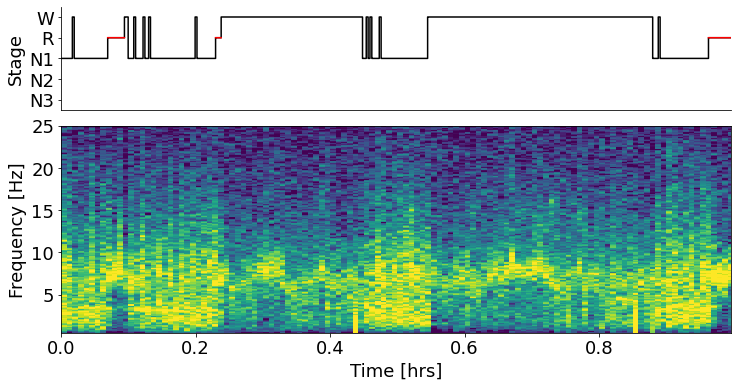

In [50]:
# sls = yasa.SleepStaging(raw, eeg_name='EEG EEG1A-B', emg_name='EMG EEG3A-B')
# hypno_pred = sls.predict()  # Predict the sleep stages
# hypno_pred = yasa.hypno_str_to_int(hypno_pred)  # Convert "W" to 0, "N1" to 1, etc
hypno_up = yasa.hypno_upsample_to_data(scores_converted, sf_hypno=1/10, data=raw, sf_data = 100)
# yasa.plot_hypnogram(hypno_pred);  # Plot
yasa.plot_spectrogram(raw._data[0], sf, hypno_up, cmap = 'viridis');
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("day1_CH2_hypnogram.jpg")

In [51]:
#spindle detection
# pull out EEG1 and 2
raw.pick_types(eeg=True).drop_channels(['EMG EEG3.1A-B'])
print('Chan =', raw.ch_names)

Chan = ['EEG EEG1.1A-B', 'EEG EEG2.1A-B']


In [52]:
# Multi-channel spindles detection
# Note that since we're using a MNE Raw object, there is no need
# to manually specify the sampling frequency and channel names: 
# they will be automatically inferred from the Raw object.
sp = yasa.spindles_detect(raw._data*1000000,sf=100, hypno=hypno_up, freq_sp=[9, 16], freq_broad=[1, 30], duration=[0.5, 1.5], min_distance=500, thresh={'rel_pow': 0.2, 'corr': None, 'rms': 3})
# sp.summary() #hypno_up

In [13]:
#spindle summary
df1 = sp.summary() #(grp_chan=True, aggfunc='mean')
# df1.to_csv('EEG_recordings/346/mouse_346_spindles_day1.csv')
mouse_208_day1_EEG1 = df1[df1.IdxChannel==0]
mouse_208_d1_CH1 = mouse_208_day1_EEG1.shape[0]
print(mouse_208_d1_CH1)
mouse_208_day1_EEG2 = df1[df1.IdxChannel==1]
mouse_208_d1_CH2 = mouse_208_day1_EEG2.shape[0]
print(mouse_208_d1_CH2)

148
283


([<matplotlib.axis.XTick at 0x1d890efd248>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

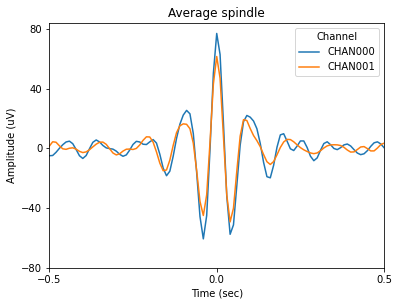

In [10]:
#plot average spindle
ax = sp.plot_average(center='Peak', time_before=0.5, time_after=0.5, filt=(9, 16), ci=None)
# plt.ylim(-80,90)
plt.yticks([-80,-40,0,40,80])
plt.xlim(-0.50,0.50)
plt.xticks([-0.5,0,0.5])
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("mouse_208_day1_spindle_ave.svg")

In [20]:
#spindle summary
df2 = sp.summary() #(grp_chan=True, aggfunc='mean')
# df2.to_csv('EEG_recordings/346/mouse_346_spindles_day2.csv')
mouse_208_day2_EEG1 = df2[df2.IdxChannel==0]
mouse_208_d2_CH1 = mouse_208_day2_EEG1.shape[0]
print(mouse_208_d2_CH1)
mouse_208_day2_EEG2 = df2[df2.IdxChannel==1]
mouse_208_d2_CH2 = mouse_208_day2_EEG2.shape[0]
print(mouse_208_d2_CH2)

191
279


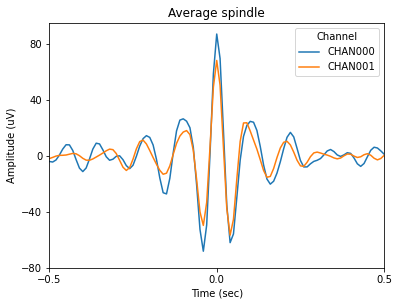

In [389]:
#plot average spindle
ax = sp.plot_average(center='Peak', time_before=0.5, time_after=0.5, filt=(9, 16), ci=None)
# plt.ylim(-80,90)
plt.yticks([-80,-40,0,40,80])
plt.xlim(-0.50,0.50)
plt.xticks([-0.5,0,0.5])
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("mouse_208_day2_spindle_ave.svg")

In [27]:
#spindle summary
df3 = sp.summary() #(grp_chan=True, aggfunc='mean')
# df2.to_csv('EEG_recordings/346/mouse_346_spindles_day2.csv')
mouse_268_day1_EEG1 = df3[df3.IdxChannel==0]
mouse_268_d1_CH1 = mouse_268_day1_EEG1.shape[0]
print(mouse_268_d1_CH1)
mouse_268_day1_EEG2 = df3[df3.IdxChannel==1]
mouse_268_d1_CH2 = mouse_268_day1_EEG2.shape[0]
print(mouse_268_d1_CH2)

187
154


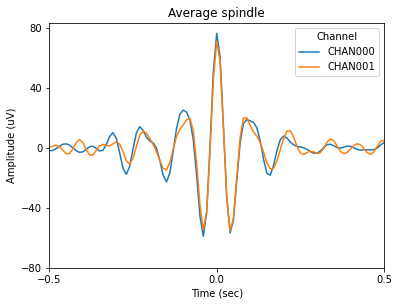

In [431]:
#plot average spindle
ax = sp.plot_average(center='Peak', time_before=0.5, time_after=0.5, filt=(9, 16), ci=None)
# plt.ylim(-80,90)
plt.yticks([-80,-40,0,40,80])
plt.xlim(-0.50,0.50)
plt.xticks([-0.5,0,0.5])
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("mouse_268_day1_spindle_ave.svg")

In [34]:
#spindle summary
df4 = sp.summary() #(grp_chan=True, aggfunc='mean')
# df2.to_csv('EEG_recordings/346/mouse_346_spindles_day2.csv')
mouse_268_day2_EEG1 = df4[df4.IdxChannel==0]
mouse_268_d2_CH1 = mouse_268_day2_EEG1.shape[0]
print(mouse_268_d2_CH1)
mouse_268_day2_EEG2 = df4[df4.IdxChannel==1]
mouse_268_d2_CH2 = mouse_268_day2_EEG2.shape[0]
print(mouse_268_d2_CH2)

254
256


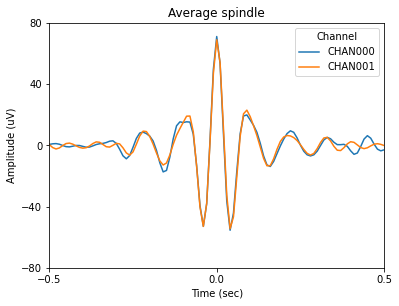

In [440]:
#plot average spindle
ax = sp.plot_average(center='Peak', time_before=0.5, time_after=0.5, filt=(9, 16), ci=None)
# plt.ylim(-80,90)
plt.yticks([-80,-40,0,40,80])
plt.xlim(-0.50,0.50)
plt.xticks([-0.5,0,0.5])
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("mouse_268_day2_spindle_ave.svg")

In [46]:
#spindle summary
df5 = sp.summary() #(grp_chan=True, aggfunc='mean')
# df2.to_csv('EEG_recordings/346/mouse_346_spindles_day2.csv')
mouse_346_day1_EEG1 = df5[df5.IdxChannel==0]
mouse_346_d1_CH1 = mouse_346_day1_EEG1.shape[0]
print(mouse_346_d1_CH1)
mouse_346_day1_EEG2 = df5[df5.IdxChannel==1]
mouse_346_d1_CH2 = mouse_346_day1_EEG2.shape[0]
print(mouse_346_d1_CH2)

90
78


([<matplotlib.axis.XTick at 0x208c7185348>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

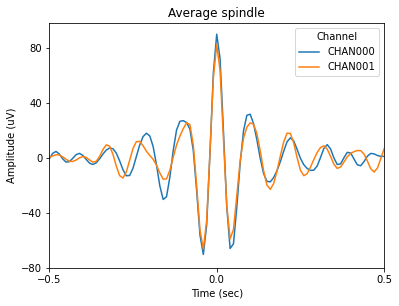

In [414]:
#plot average spindle
ax = sp.plot_average(center='Peak', time_before=0.5, time_after=0.5, filt=(9, 16), ci=None)
# plt.ylim(-80,90)
plt.yticks([-80,-40,0,40,80])
plt.xlim(-0.50,0.50)
plt.xticks([-0.5,0,0.5])
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("day2_spindle_ave.svg")

In [53]:
#spindle summary
df6 = sp.summary() #(grp_chan=True, aggfunc='mean')
# df2.to_csv('EEG_recordings/346/mouse_346_spindles_day2.csv')
mouse_346_day2_EEG1 = df6[df6.IdxChannel==0]
mouse_346_d2_CH1 = mouse_346_day2_EEG1.shape[0]
print(mouse_346_d2_CH1)
mouse_346_day2_EEG2 = df6[df6.IdxChannel==1]
mouse_346_d2_CH2 = mouse_346_day2_EEG2.shape[0]
print(mouse_346_d2_CH2)

140
129


([<matplotlib.axis.XTick at 0x208c650e408>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

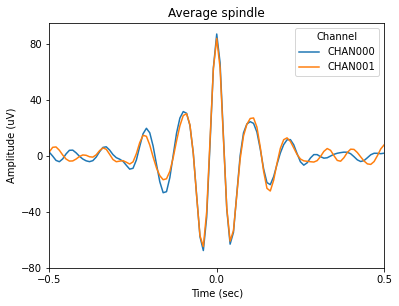

In [422]:
#plot average spindle
ax = sp.plot_average(center='Peak', time_before=0.5, time_after=0.5, filt=(9, 16), ci=None)
# plt.ylim(-80,90)
plt.yticks([-80,-40,0,40,80])
plt.xlim(-0.50,0.50)
plt.xticks([-0.5,0,0.5])
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("day2_spindle_ave.svg")

In [54]:
d1_CH1 = mouse_208_d1_CH1+mouse_268_d1_CH1+mouse_346_d1_CH1
d1_CH2 = mouse_208_d1_CH2+mouse_268_d1_CH2+mouse_346_d1_CH2
print(d1_CH1)
print(d1_CH2)
d2_CH1 = mouse_208_d2_CH1+mouse_268_d2_CH1+mouse_346_d2_CH1
d2_CH2 = mouse_208_d2_CH2+mouse_268_d2_CH2+mouse_346_d2_CH2
print(d2_CH1)
print(d2_CH2)

425
515
585
664


In [55]:
mouse_208_day1_EEG1.Oscillations,mouse_268_day1_EEG1.Oscillations, mouse_346_day1_EEG1.Oscillations, mouse_208_day2_EEG1.Oscillations, mouse_268_day2_EEG1.Oscillations,  mouse_346_day2_EEG1.Oscillations, mouse_208_day1_EEG2.Oscillations, mouse_268_day1_EEG2.Oscillations, mouse_346_day1_EEG2.Oscillations, mouse_208_day2_EEG2.Oscillations, mouse_268_day2_EEG2.Oscillations, mouse_346_day2_EEG2.Oscillations

(0      12.0
 1      12.0
 2      15.0
 3      12.0
 4       5.0
        ... 
 143    15.0
 144    14.0
 145     8.0
 146    10.0
 147    16.0
 Name: Oscillations, Length: 148, dtype: float64,
 0      11.0
 1       9.0
 2      11.0
 3       9.0
 4      17.0
        ... 
 182    12.0
 183    16.0
 184    13.0
 185    12.0
 186    17.0
 Name: Oscillations, Length: 187, dtype: float64,
 0     14.0
 1     10.0
 2     11.0
 3      7.0
 4      6.0
       ... 
 85     9.0
 86     8.0
 87    10.0
 88    10.0
 89    10.0
 Name: Oscillations, Length: 90, dtype: float64,
 0       7.0
 1      17.0
 2      16.0
 3      12.0
 4      11.0
        ... 
 186    14.0
 187     7.0
 188    13.0
 189    11.0
 190    11.0
 Name: Oscillations, Length: 191, dtype: float64,
 0      12.0
 1       6.0
 2       7.0
 3      13.0
 4       6.0
        ... 
 249     7.0
 250    17.0
 251    13.0
 252     7.0
 253    14.0
 Name: Oscillations, Length: 254, dtype: float64,
 0       7.0
 1       7.0
 2       6.0
 3      

In [56]:
group_dict = ['day1_ch1']*(d1_CH1)+['day2_ch1']*(d2_CH1)+['day1_ch2']*(d1_CH2)+['day2_ch2']*(d2_CH2)
duration = np.concatenate((mouse_208_day1_EEG1.Duration,mouse_268_day1_EEG1.Duration, mouse_346_day1_EEG1.Duration, mouse_208_day2_EEG1.Duration, mouse_268_day2_EEG1.Duration,  mouse_346_day2_EEG1.Duration, mouse_208_day1_EEG2.Duration, mouse_268_day1_EEG2.Duration, mouse_346_day1_EEG2.Duration, mouse_208_day2_EEG2.Duration, mouse_268_day2_EEG2.Duration, mouse_346_day2_EEG2.Duration))
amplitude = np.concatenate((mouse_208_day1_EEG1.Amplitude,mouse_268_day1_EEG1.Amplitude, mouse_346_day1_EEG1.Amplitude, mouse_208_day2_EEG1.Amplitude, mouse_268_day2_EEG1.Amplitude,  mouse_346_day2_EEG1.Amplitude, mouse_208_day1_EEG2.Amplitude, mouse_268_day1_EEG2.Amplitude, mouse_346_day1_EEG2.Amplitude, mouse_208_day2_EEG2.Amplitude, mouse_268_day2_EEG2.Amplitude, mouse_346_day2_EEG2.Amplitude))
frequency = np.concatenate((mouse_208_day1_EEG1.Frequency,mouse_268_day1_EEG1.Frequency, mouse_346_day1_EEG1.Frequency, mouse_208_day2_EEG1.Frequency, mouse_268_day2_EEG1.Frequency,  mouse_346_day2_EEG1.Frequency, mouse_208_day1_EEG2.Frequency, mouse_268_day1_EEG2.Frequency, mouse_346_day1_EEG2.Frequency, mouse_208_day2_EEG2.Frequency, mouse_268_day2_EEG2.Frequency, mouse_346_day2_EEG2.Frequency))
oscillations = np.concatenate((mouse_208_day1_EEG1.Oscillations,mouse_268_day1_EEG1.Oscillations, mouse_346_day1_EEG1.Oscillations, mouse_208_day2_EEG1.Oscillations, mouse_268_day2_EEG1.Oscillations,  mouse_346_day2_EEG1.Oscillations, mouse_208_day1_EEG2.Oscillations, mouse_268_day1_EEG2.Oscillations, mouse_346_day1_EEG2.Oscillations, mouse_208_day2_EEG2.Oscillations, mouse_268_day2_EEG2.Oscillations, mouse_346_day2_EEG2.Oscillations))


data_count = {'Groups': group_dict, 
        'duration': duration,
        'amplitude': amplitude,
        'frequency': frequency,
        'oscillations': oscillations,
}
df_spindles = pd.DataFrame(data_count)

print(df_spindles)

        Groups  duration   amplitude  frequency  oscillations
0     day1_ch1      0.94  277.904589  12.205398          12.0
1     day1_ch1      1.10  453.343887  10.245656          12.0
2     day1_ch1      1.35  406.829891  10.971703          15.0
3     day1_ch1      0.99  429.253631  11.840606          12.0
4     day1_ch1      0.65  350.175308  10.973485           5.0
...        ...       ...         ...        ...           ...
2184  day2_ch2      1.26  495.265293  10.852879          11.0
2185  day2_ch2      0.72  559.279137   9.474895           6.0
2186  day2_ch2      0.62  392.714451  11.268561           7.0
2187  day2_ch2      1.01  485.774393  11.950755          12.0
2188  day2_ch2      0.99  468.592509  11.280467          10.0

[2189 rows x 5 columns]


In [58]:
df_spindles[df_spindles.Groups=='day1_ch1'].duration

0      0.94
1      1.10
2      1.35
3      0.99
4      0.65
       ... 
420    0.87
421    0.79
422    0.95
423    0.99
424    0.93
Name: duration, Length: 425, dtype: float64

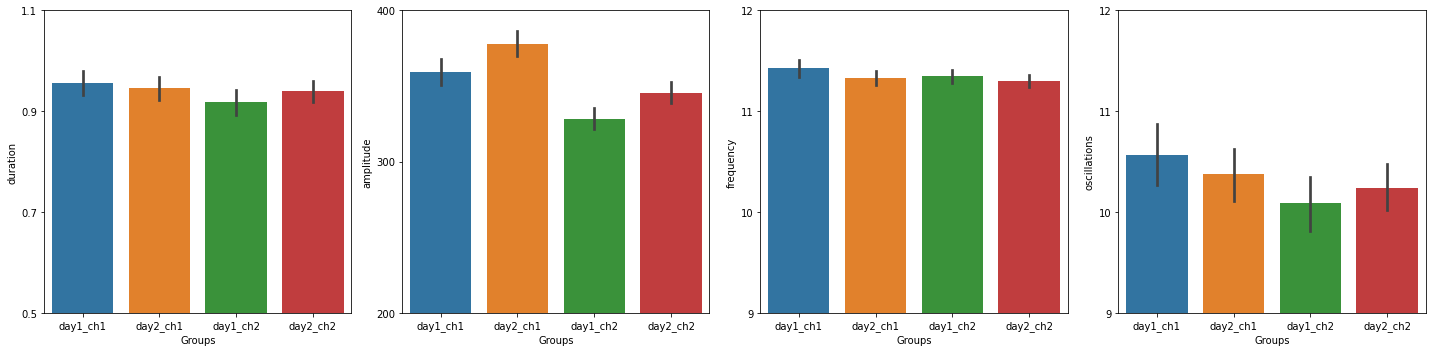

In [92]:
fig, axs = plt.subplots(nrows=1,ncols=4,figsize = (20,5))
sns.barplot(x="Groups", y="duration",data = df_spindles,ax=axs[0])
# sns.stripplot(x = "Groups",
#               y = "duration",
#               color = 'black',
#               data = df_spindles,ax=axs[0])

sns.barplot(x="Groups", y="amplitude",data = df_spindles,ax=axs[1])
# sns.stripplot(x = "Groups",
#               y = "amplitude", 
#               color = 'black',
#               data = df_spindles,ax=axs[1])

sns.barplot(x="Groups", y="frequency",data = df_spindles,ax=axs[2])
# sns.stripplot(x = "Groups",
#               y = "frequency",
#               color = 'black',
#               data = df_spindles,ax=axs[2])

sns.barplot(x="Groups", y="oscillations",data = df_spindles,ax=axs[3])
# sns.stripplot(x = "Groups",
#               y = "oscillations", 
#               color = 'black',
#               data = df_spindles,ax=axs[3])


axs[0].set_ylim(0.5,1)
axs[0].set_yticks(np.arange(0.5, 1.2, 0.2))
axs[1].set_ylim(200,400)
axs[1].set_yticks(np.arange(200, 401, 100))
axs[2].set_ylim(9,12)
axs[2].set_yticks(np.arange(9, 12.5, 1))
axs[3].set_ylim(9,12)
axs[3].set_yticks(np.arange(9, 12.5, 1))

plt.tight_layout()
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("absolute_change_spike_count.svg")

# sums_pvalue=scipy.stats.ranksums(het_per_change,wt_per_change, alternative='two-sided')
# min_pvalue = scipy.stats.ranksums(het_per_change_spon,wt_per_change_spon, alternative='two-sided')
# print(sums_pvalue)
# print(min_pvalue)

# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("spindle_barplots.svg")

plt.show()

In [91]:
#this is for paired t tests

from scipy.stats import ttest_ind

cat1 = df_spindles[df_spindles['Groups']=='day1_ch1']
cat2 = df_spindles[df_spindles['Groups']=='day2_ch1']

ttest_ind(cat1['frequency'], cat2['frequency'])

Ttest_indResult(statistic=1.7225426781708535, pvalue=0.0852779871237849)